### Agentic Data generation with CAMEL and finetuning Qwen models with Unsloth

For more detailed usage information, please refer to our [cookbook](https://colab.research.google.com/drive/1sMnWOvdmASEMhsRIOUSAeYuEywby6FRV?usp=sharing)

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>

CAMEL and Unsloth make an excellent pair. In this notebook we will combine the two to train a model to be proficient at content on a page

You will learn how to do data generation with CAMEL, how to train, and how to run the model.

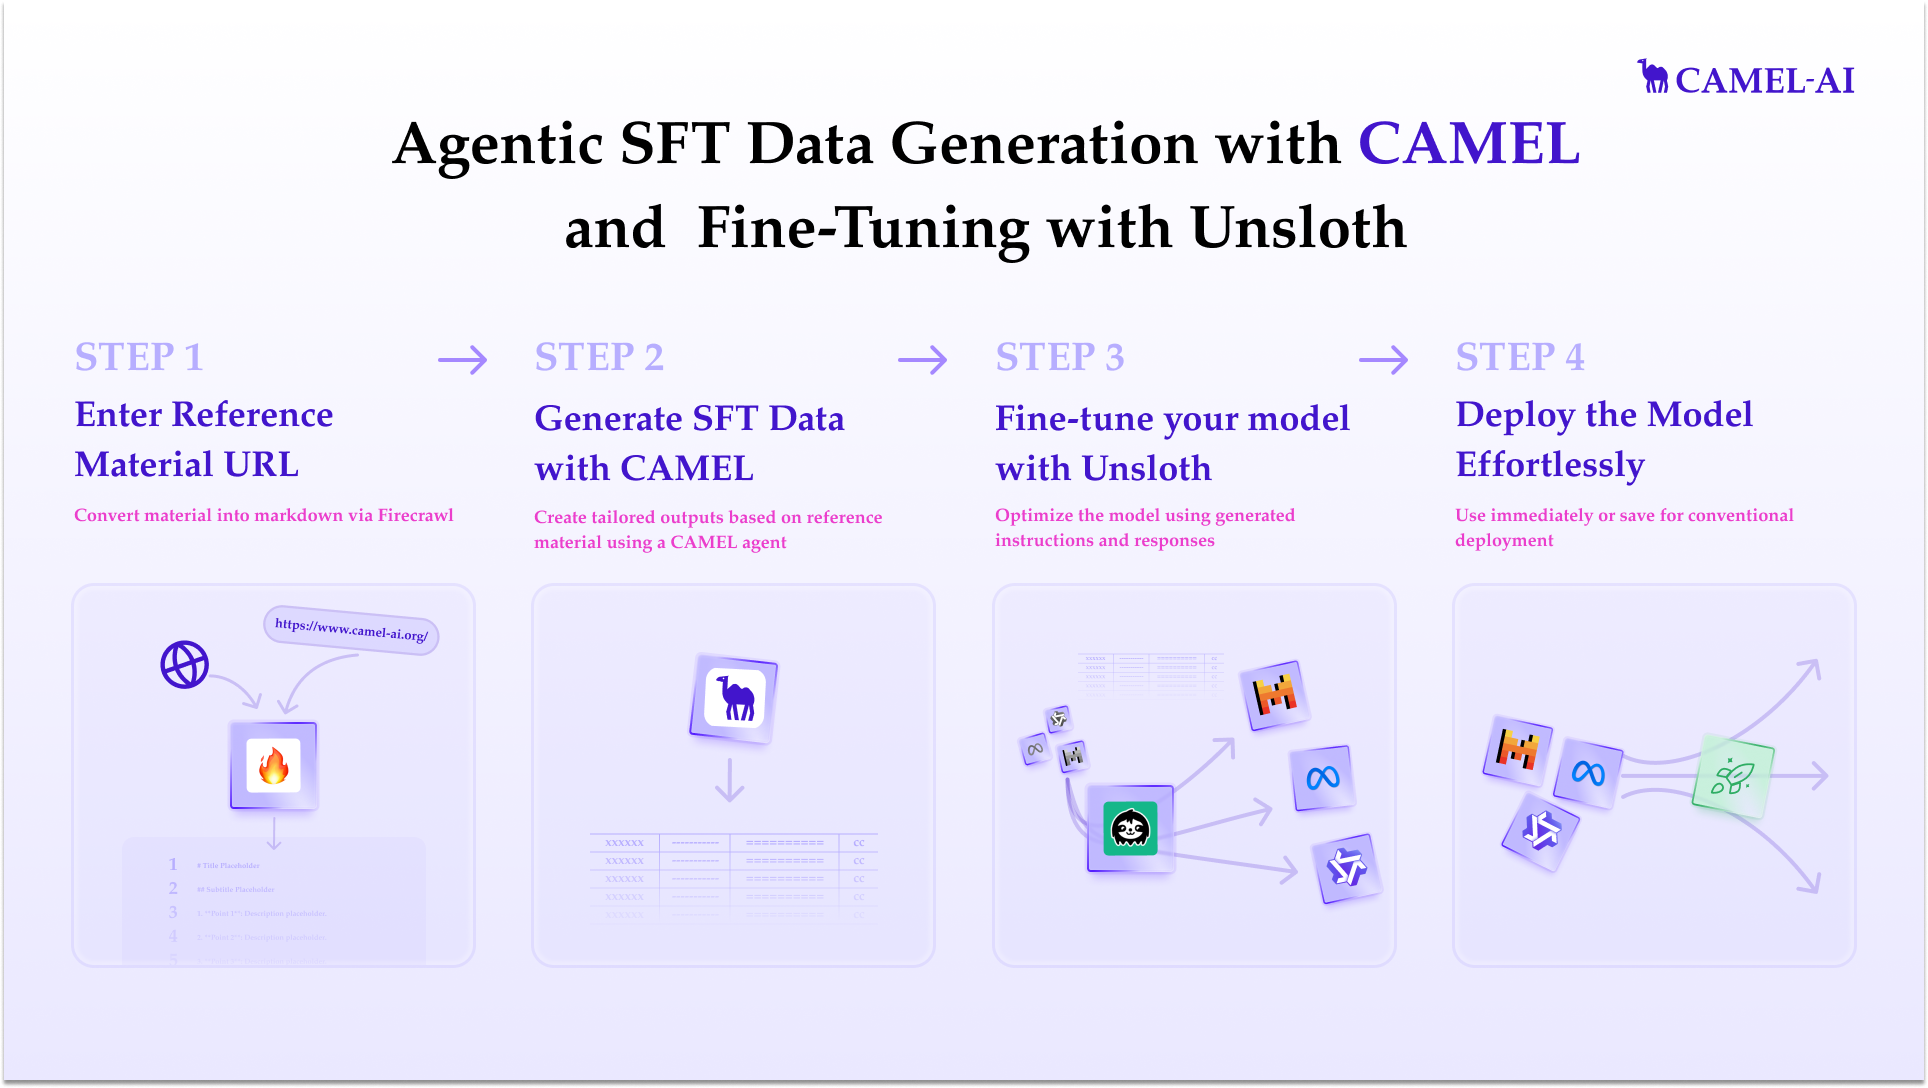

In [ ]:
%%capture
!pip install unsloth
# Install CAMEL-AI with no optional dependencies
!pip install camel-ai==0.2.16
# Get Unsloth latest unsloth nightly
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git
!pip install firecrawl

First we will set the OPENAI_API_KEY that will be used to generate the data.

CAMEL supports many other models. See [here](https://docs.camel-ai.org/key_modules/models.html) for a list.

In [ ]:
from getpass import getpass
import os

openai_api_key = getpass('Enter your OpenAI API key: ')
os.environ["OPENAI_API_KEY"] = openai_api_key

# Generate an API key at https://www.firecrawl.dev/app/api-keys
firecrawl_api_key = getpass('Enter your Firecrawl API key: ')
os.environ["FIRECRAWL_API_KEY"] = firecrawl_api_key

Enter your OpenAI API key: ··········
Enter your Firecrawl API key: ··········


Alternatively, if running on Colab, you could save your API keys and tokens as **Colab Secrets**, and use them across notebooks.

To do so, **comment out** the above **manual** API key prompt code block(s), and **uncomment** the following codeblock.

⚠️ Don't forget granting access to the API key you would be using to the current notebook.

In [ ]:
# import os
# from google.colab import userdata

# os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
# os.environ["FIRECRAWL_API_KEY"] = userdata.get("FIRECRAWL_API_KEY")

Next we will setup our model for training using Unsloth.

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2.5-7B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.4: Fast Qwen2 patching. Transformers:4.47.0.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.87k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Unsloth 2024.12.4 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


Now as a control, lets see how this model does with our CAMEL-specific question

In [ ]:
from camel.messages.conversion import AlpacaItem

temp_model = FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[

   AlpacaItem(
       instruction="Explain how can I stay up to date with the CAMEL community.",
       input="",
       output="", # leave this blank for generation!
   ).to_string()

], return_tensors = "pt").to("cuda")

outputs = temp_model.generate(**inputs, max_new_tokens = 512, use_cache = True)
temp_model = None
tokenizer.batch_decode(outputs)


['### Instruction:\nExplain how can I stay up to date with the CAMEL community.\n\n### Input:\n\n\n### Response:\nStaying up to date with the CAMEL community can be done in several ways:\n\n1. Join the CAMEL mailing list: You can join the CAMEL mailing list to receive updates on the latest developments, news, and events related to the CAMEL community. You can subscribe to the mailing list by sending an email to [email protected] with the subject line "subscribe".\n2. Follow CAMEL on social media: CAMEL has an active presence on social media platforms such as Twitter, LinkedIn, and Facebook. You can follow CAMEL on these platforms to stay up to date with the latest news and events.\n3. Attend CAMEL events: CAMEL hosts various events throughout the year, including conferences, workshops, and webinars. Attending these events can provide you with the opportunity to network with other members of the CAMEL community and learn about the latest developments in the field.\n4. Read CAMEL publica

It seems to very broadly know what CAMEL is, but gives some hallucinations and says nothing concrete. We can do better.

### Data models
We want to generate data in the Alpaca format, so we can use CAMEL's built-in AlpacaItem class which has some handy conversion functions for us.

We will be using CAMEL's structured output to generate all of these items in one request, which is much faster and cheaper.


Here we create a wrapper around the AlpacaItem to help the model know how many have been generated as it's going along, and another wrapper class that represents a list of these.

In [ ]:
from pydantic import BaseModel

class NumberedAlpacaItem(BaseModel):
    number: int
    item: AlpacaItem


class AlpacaItemResponse(BaseModel):
    """
    Represents an instruction-response item in the Alpaca format.
    """
    items: list[NumberedAlpacaItem]

<a name="Data"></a>
### Data generation
Next we define our data generation function. It takes a source content, and generates a list of instruction-input-response triplets around it.

We will use this later to train our model to be proficient with the source content.

In [ ]:
from typing import List
from camel.loaders import Firecrawl
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType
from camel.configs import ChatGPTConfig
from camel.agents import ChatAgent
import json


def generate_alpaca_items(content: str, n_items: int, start_num: int = 1, examples: List[AlpacaItem] = None) -> List[AlpacaItem]:
    system_msg = """
You are an AI assistant generating detailed, accurate responses based on the provided content.
You will be given a reference content, and you must generate a specific number of AlpacaItems.
These are instruction-input-response triplets, where the input is the context or examples.

Add a number to the items to keep track of the order. Generate exactly that many.

For each instruction, imagine but do not include a real world scenario and real user in that scenario to inform realistic and varied instructions. Avoid common sense questions and answers.

Include multiple lines in the output as appropriate to provide sufficient detail. Cite the most relevant context verbatim in output fields, do not omit anything important.

Leave the input field blank.

Ensure all of the most significant parts of the context are covered.

Start with open ended instructions, then move to more specific ones. Consider the starting number for an impression of what has already been generated.
    """

    examples_str = ""
    if examples:
        examples_str = "\n\nHere are some example items for reference:\n" + \
            "\n".join(ex.model_dump_json() for ex in examples)

    model = ModelFactory.create(
        model_platform=ModelPlatformType.OPENAI,
        model_type=ModelType.GPT_4O_MINI,
        model_config_dict=ChatGPTConfig(
            temperature=0.6, response_format=AlpacaItemResponse
        ).as_dict(),
    )

    agent = ChatAgent(
        system_message=system_msg,
        model=model,
    )

    prompt = f"Content reference:\n{content}{examples_str}\n\n Generate {n_items} AlpacaItems. The first should start numbering at {start_num}."
    response = agent.step(prompt)

    # Parse the generated JSON to our wrapper class
    alpaca_items = [n_item.item for n_item in
                    AlpacaItemResponse.
                    model_validate_json(response.msgs[0].content).items]

    return alpaca_items


def save_json(data: List, filename: str):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump([entry.model_dump() for entry in data], f, indent=2,
                  ensure_ascii=False)


# Few shot examples to ensure the right amount of detail
examples = [
    AlpacaItem(
        instruction="Explain the process for sprint planning and review in CAMEL.",
        input="",
        output="The process for sprint planning and review in CAMEL includes:\n1. **Sprint Duration**: Each sprint lasts two weeks for development and one week for review.\n2. **Planning Meeting**: Conducted biweekly, where the founder highlights the sprint goal and developers select items for the sprint.\n3. **Review Meeting**: Stakeholders review the delivered features and provide feedback on the work completed during the sprint."
    )
]



# Point to content and generate data!
Now we point to the content that we wish to generate SFT data around and use CAMEL's Firecrawl integration to get this content in a nice markdown format.

You can get a Firecrawl API key from [here](https://www.firecrawl.dev/app/api-keys)

In [ ]:
import random
firecrawl = Firecrawl()
# Scrape and clean content from a specified URL
response = firecrawl.scrape(
    url="https://github.com/camel-ai/camel/blob/master/CONTRIBUTING.md"
)

# Generate the items 50 a time up to 300
alpaca_entries = []
for start in range(1, 301, 50):
    # Combine default examples with random samples from previous generations
    current_examples = examples + (random.sample(alpaca_entries,
                                                 min(5, len(alpaca_entries)))
                                                  if alpaca_entries else [])

    batch = generate_alpaca_items(
        content=response["markdown"],
        n_items=50,
        start_num=start,
        examples=current_examples
    )
    print(f"Generated {len(batch)} items")
    alpaca_entries.extend(batch)

print(alpaca_entries)
save_json(alpaca_entries, 'alpaca_format_data.json')

Generated 50 items
Generated 50 items
Generated 50 items
Generated 50 items
Generated 50 items
Generated 40 items
[AlpacaItem(instruction='Describe the contributing guidelines for the CAMEL project.', input='', output='The contributing guidelines for the CAMEL project include:\n- Follow the Fork-and-Pull-Request workflow for community contributors.\n- Members of CAMEL-AI.org should use the Checkout-and-Pull-Request workflow.\n- Ensure that all pull requests pass formatting, linting, and testing checks before merging.\n- High-quality documentation and thorough testing are essential for contributions.'), AlpacaItem(instruction='What are the steps to write a cookbook for CAMEL?', input='', output='Steps to write a cookbook for CAMEL include:\n1. **Template Usage**: Use the provided Google Colab template for consistency.\n2. **Writing**: Start writing in Colab, ensuring correctness of LLM-generated responses.\n3. **Reviewing**: Conduct reviews directly in Colab, focusing on accuracy and cl

Now to define how each row is formatted

In [ ]:
EOS_TOKEN = tokenizer.eos_token

# Provide function showing how to convert dataset row into inference text
def formatting_prompts_func(dataset_row):
    return {
        "text": [
            AlpacaItem(instruction=inst, input=inp, output=out)
                        .to_string() + EOS_TOKEN # Use handy to_string method
            for inst, inp, out in zip(
                dataset_row["instruction"],
                dataset_row["input"],
                dataset_row["output"]
            )
        ]
    }

from datasets import load_dataset
dataset = load_dataset("json", data_files="alpaca_format_data.json", split="train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/290 [00:00<?, ? examples/s]

Train the model

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

# Ensure model is fully back in training mode
model = FastLanguageModel.for_training(model)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Packs short sequences together to save time!
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 30,
        learning_rate = 0.001,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Map (num_proc=2):   0%|          | 0/290 [00:00<?, ? examples/s]

In [ ]:
dtrainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 290 | Num Epochs = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 1,080
 "-____-"     Number of trainable parameters = 40,370,176


Step,Training Loss
1,7.647200
2,7.985900
3,7.005900
4,6.531000
5,6.312700
6,4.288900
7,3.915700
8,3.638800
9,3.806600
10,3.667800


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[

    AlpacaItem(
        instruction="Explain how can I stay up to date with the CAMEL community.",
        input="",
        output="", # leave this blank for generation!
    ).to_string()

], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 512, use_cache = True)
tokenizer.batch_decode(outputs)

['### Instruction:\nExplain how can I stay up to date with the CAMEL community.\n\n### Input:\n\n\n### Response:\nTo stay up to date with the CAMEL community, follow these steps:\n1. **Participate in Discussions**: Actively join conversations in Discord and Slack channels.\n2. **Review Documentation**: Regularly read the documentation to understand project updates.\n3. **Engage with the Community**: Attend meetings and contribute to discussions to keep abreast of developments.<|endoftext|>']

**Summary**


We have generated realistic user queries and responses from a real page and trained on them to produce a model that understands the underlying content.

That's everything: Got questions about 🐫 CAMEL-AI? Join us on [Discord](https://discord.camel-ai.org)! Whether you want to share feedback, explore the latest in multi-agent systems, get support, or connect with others on exciting projects, we’d love to have you in the community! 🤝

Check out some of our other work:

1. 🐫 Creating Your First CAMEL Agent [free Colab](https://docs.camel-ai.org/cookbooks/create_your_first_agent.html)

2.  Graph RAG Cookbook [free Colab](https://colab.research.google.com/drive/1uZKQSuu0qW6ukkuSv9TukLB9bVaS1H0U?usp=sharing)

3. 🧑‍⚖️ Create A Hackathon Judge Committee with Workforce [free Colab](https://colab.research.google.com/drive/18ajYUMfwDx3WyrjHow3EvUMpKQDcrLtr?usp=sharing)

4. 🔥 3 ways to ingest data from websites with Firecrawl & CAMEL [free Colab](https://colab.research.google.com/drive/1lOmM3VmgR1hLwDKdeLGFve_75RFW0R9I?usp=sharing)

5. 🦥 Agentic SFT Data Generation with CAMEL and Mistral Models, Fine-Tuned with Unsloth [free Colab](https://colab.research.google.com/drive/1lYgArBw7ARVPSpdwgKLYnp_NEXiNDOd-?usp=sharing)

6. 🦥 Agentic SFT Data Generation with CAMEL and Meta Models, Fine-Tuned with Unsloth [free Colab](https://colab.research.google.com/drive/1fdBns2QA1XNwF_tsvG3Hc27QGdViHH3b?usp=sharing)

Thanks from everyone at 🐫 CAMEL-AI


<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>